In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta as rd
import schedule
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy.stats

In [5]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args,**kw):
        tstart = time()
        result = f(*args,**kw)
        tend = time()
        print('func:%r args: [%r,%r] took: %2.4f sec' % \
              (f.__name__,args,kw,tend-tstart))
        return result
    return wrap
        
        
    

In [6]:
#Inputs
r = 0.06 # Risk-free rate taken from US treasury bonds 
sigma = 0.2
mu = 0.06
seed = None
S0 = 100 #Initial Stock Price
K = 100  #Strike Price
T = 1    #Time to Maturity in Years
N = 4   #Number of Time Steps
u = 1.1  #up-factor in binomial model
d = 1/u  #down-factor in binomial model
optiontype = 'P' #Choose 'C' for call & 'P' for Put
num_paths = 3


In [7]:
def gbm_stock_price(S0, mu, sigma, T, N, seed=None):
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1) 
    W = np.cumsum(W) * np.sqrt(dt)  # Brownian motion
    X = (r - 0.5 * sigma**2) * t + sigma * W  # GBM process
    S = S0 * np.exp(X)  # Stock price process
    S[0] = S0
    return S

In [30]:
X = np.zeros((num_paths, N))
W = np.zeros((num_paths, N))

np.random.seed(seed)
dt = T / N
t = np.linspace(0, T, N)

for path in range(num_paths):
    # Generate random samples from a normal distribution
    random_samples = np.random.normal(size=N)
    
    # Scale the random samples by the square root of the time step
    scaled_samples = np.sqrt(dt) * random_samples
    
    # Cumulatively sum the scaled samples to simulate Brownian motion
    W[path,:] = np.cumsum(scaled_samples)
    X[path,:] = S0*np.exp((mu - 0.5 * sigma**2) * t + sigma * W[path,:])
X[:,0] = S0


In [31]:
X

array([[100.        , 117.54154967, 124.13669964, 120.90291356],
       [100.        ,  82.4674676 ,  87.37394225,  94.65304652],
       [100.        , 105.39765645,  94.78144667,  90.03545201]])

In [32]:
stock_end = X[:, -1]
stock_end

array([120.90291356,  94.65304652,  90.03545201])

In [33]:
for i in range(0,N):
    payoffS = np.maximum(K-X,0)
payoffS = payoffS[:, 1:]
payoffS

array([[ 0.        ,  0.        ,  0.        ],
       [17.5325324 , 12.62605775,  5.34695348],
       [ 0.        ,  5.21855333,  9.96454799]])

In [90]:
payoffS[:,2]

array([0.        , 5.34695348, 9.96454799])

In [34]:
value_end = np.maximum(K-stock_end,0)
value_end

array([0.        , 5.34695348, 9.96454799])

In [35]:
W

array([[ 0.61150696,  0.74144183,  0.94773261,  0.74908835],
       [-0.75838133, -1.03049818, -0.80819879, -0.47476061],
       [ 0.53306492,  0.19618441, -0.40131586, -0.72483341]])

In [36]:


# Calculate time step
dt = T / N

# Initialize a list to store matrices for each time step
probability_matrices = []

# Calculate conditional probabilities for each time step
for j in range(N-2, -1, -1):
    probability_matrix = np.zeros((num_paths, num_paths))

    for k in range(num_paths):
        # Calculate the conditional probability using the log-normal distribution
        mu_conditional = np.log(X[:, j+1] / X[k, j]) / dt - 0.5 * sigma**2
        sigma_conditional = sigma * np.sqrt(dt)

        # Calculate the probability using the log-normal distribution formula
        prob = scipy.stats.norm.pdf(np.log(X[:, j+1] / X[k, j]), loc=mu_conditional, scale=sigma_conditional)

        # Normalize the probabilities to sum to 1
        prob /= np.sum(prob)

        # Store the probability in the matrix
        probability_matrix[k, :] = prob

    # Append the probability matrix for the current time step to the list
    probability_matrices.append(probability_matrix)

# Now, probability_matrices[j] represents the matrix of probabilities for time step j


In [37]:
X

array([[100.        , 117.54154967, 124.13669964, 120.90291356],
       [100.        ,  82.4674676 ,  87.37394225,  94.65304652],
       [100.        , 105.39765645,  94.78144667,  90.03545201]])

In [96]:
payoffS

array([[ 0.        ,  0.        ,  0.        ],
       [17.5325324 , 12.62605775,  5.34695348],
       [ 0.        ,  5.21855333,  9.96454799]])

In [38]:
#Organized such that the first row of any matrix is the transition probabilities from the top node,
# to all nodes in the next time step, and then goes down the column of nodes repeating process for each row
#matrix 0 in list corresponds to time step J-1
probability_matrices

[array([[1.00000000e+00, 1.34299428e-15, 1.61393798e-21],
        [1.91178172e-20, 1.01903651e-01, 8.98096349e-01],
        [9.33637555e-12, 8.15591939e-01, 1.84408061e-01]]),
 array([[9.99999999e-01, 2.98830519e-18, 6.71673656e-10],
        [7.55919022e-32, 9.98800224e-01, 1.19977575e-03],
        [4.68078588e-03, 1.30272406e-05, 9.95306187e-01]]),
 array([[5.23887175e-05, 4.35254295e-08, 9.99947568e-01],
        [5.23887175e-05, 4.35254295e-08, 9.99947568e-01],
        [5.23887175e-05, 4.35254295e-08, 9.99947568e-01]])]

In [40]:
probability_matrices[0][0,:]


array([1.00000000e+00, 1.34299428e-15, 1.61393798e-21])

In [95]:
payoffS[:,2]

array([0.        , 5.34695348, 9.96454799])

In [104]:
k = 0
for j in range(num_paths-1,-1,-1):
    for i in range(num_paths):
        cont_matrix[i][j] = np.dot(probability_matrices[k][i,:],payoffS[:,j])
    k+=1

In [101]:
cont_matrix = np.zeros((num_paths,N-1))
for k in range(num_paths):
    for j in range(num_paths-1,-1,-1):
        for i in range(num_paths):
            cont_matrix[k][j] = np.dot(probability_matrices[j][i,:],payoffS[:,j])
        
np.dot(probability_matrices[0][0,:],payoffS[:,2])   

7.180943995204235e-15

In [105]:
cont_matrix

array([[7.63111002e-07, 3.50516483e-09, 7.18094400e-15],
       [7.63111002e-07, 1.26171704e+01, 9.49399825e+00],
       [7.63111002e-07, 5.19422290e+00, 6.19847513e+00]])

In [103]:
for k in range(num_paths):
    for j in range(num_paths-1,-1,-1):
        for i in range(num_paths):
            print(k,j,i)

0 2 0
0 2 1
0 2 2
0 1 0
0 1 1
0 1 2
0 0 0
0 0 1
0 0 2
1 2 0
1 2 1
1 2 2
1 1 0
1 1 1
1 1 2
1 0 0
1 0 1
1 0 2
2 2 0
2 2 1
2 2 2
2 1 0
2 1 1
2 1 2
2 0 0
2 0 1
2 0 2


In [ ]:
cont_matrix = np.zeros((num_paths,N-1))
for k in range(num_paths):
    for i in range(num_paths):
        for j in range(num_paths-1,-1,-1):
            cont_matrix[k][j] = np.dot(probability_matrices[k][i,:],payoffS[:,j])
        
np.dot(probability_matrices[0][1,:],payoffS[:,2]) 

In [96]:
#Brownian Bridge Calculation for one time step
matrixcount = (N-1)*num_paths
matrix_list = []

for i in range(matrixcount):
    matrix = np.zeros((num_paths,num_paths))
    for j in range(N-2,-1,-1):
        for k in range(num_paths):
            matrix[j,k] = X[k,j]+(X[k,j+1]-X[k,j])*(j/N)+B0
    matrix_list.append(matrix)

mesh_matrix = np.array(matrix_list)


/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1824: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [87]:
transition_matrix = np.zeros((N,N+1))
for j in range(N-2,-1,-1):
    for i in range(0,N-1):
        B0 = W[j]-W[j,0]-(j/N)/(T)*(W[T]-W[0])
        transition_matrix[i,j] = X[j]+(X[j+1]-X[j])*(j/N)+B0

IndexError: index 3 is out of bounds for axis 0 with size 3

In [33]:
n_paths = 2000  # Number of stock paths
n_steps = 252  # Number of time steps
initial_price = 100  # Initial stock price
drift = 0.05  # Drift or expected return
volatility = 0.2 # Volatility of the stock
T = 1.0  # Time to maturity

In [34]:
dt = T / n_steps
stock_paths = np.zeros((n_paths, n_steps + 1))
stock_paths[:, 0] = initial_price

for i in range(1, n_steps + 1):
    # Generate random normal samples
    Z = np.random.normal(0, 1, n_paths)
    # Calculate the Brownian motion increments
    dW = np.sqrt(dt) * Z
    # Update stock prices using the increments
    stock_paths[:, i] = stock_paths[:, i - 1] * np.exp((drift - 0.5 * volatility**2) * dt + volatility * dW)





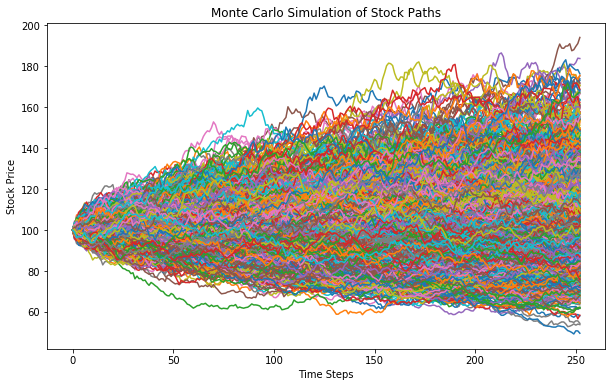

In [35]:
# Plot the simulated stock paths
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_steps + 1), stock_paths.T, lw=1.5)
plt.title('Monte Carlo Simulation of Stock Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

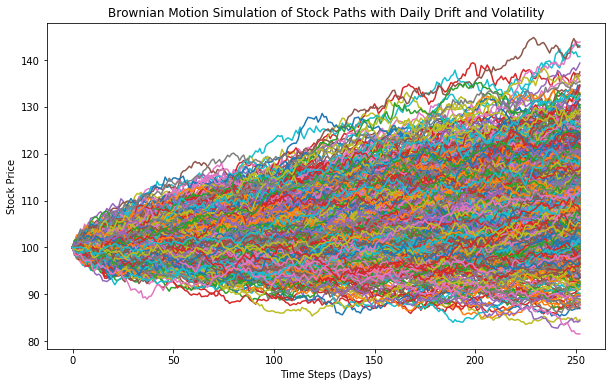

In [45]:
# Function to simulate stock paths using Brownian motion
def brownian_motion_simulation(n_paths, n_steps, initial_price, daily_drift, daily_volatility):
    dt = 1  # Assuming daily time steps

    stock_paths = np.zeros((n_paths, n_steps + 1))
    stock_paths[:, 0] = initial_price

    for i in range(1, n_steps + 1):
        # Generate random normal samples
        Z = np.random.normal(0, 1, n_paths)
        # Calculate the Brownian motion increments
        dW = np.sqrt(dt) * Z
        # Update stock prices using the increments (Geometric Brownian Motion)
        stock_paths[:, i] = stock_paths[:, i - 1] * np.exp((daily_drift - 0.5 * daily_volatility**2) * dt + daily_volatility * dW)

    return stock_paths

# Parameters
n_paths = 1000  # Number of stock paths
n_steps = 252  # Number of time steps (assuming daily)
initial_price = 100  # Initial stock price
annual_drift = 0.092  # Annual drift or expected return
annual_volatility = 0.085  # Annual volatility of the stock

# Convert annual parameters to daily values
daily_drift = (annual_drift / 252)
daily_volatility = (annual_volatility / np.sqrt(252))

# Run Brownian motion simulation
stock_paths = brownian_motion_simulation(n_paths, n_steps, initial_price, daily_drift, daily_volatility)

# Plot the simulated stock paths
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_steps + 1), stock_paths.T, lw=1.5)
plt.title('Brownian Motion Simulation of Stock Paths with Daily Drift and Volatility')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
#Brownian Bridge Calculation for one time step
matrixcount = (N-1)*num_paths
matrix_list = []

for i in range(matrixcount):
    matrix = np.zeros((num_paths,num_paths))
    for j in range(N-2,-1,-1):
        for k in range(num_paths):
            # Calculate the conditional probability using CDF of a normal distribution
            mu_conditional = X[k, j] + (X[k, -1] - X[k, j]) * (j/N)
            sigma_conditional = np.sqrt((T-j/N)*(j/N)) * sigma

            # Calculate the probability using CDF
            prob = scipy.stats.norm.cdf(X[k, j+1], loc=mu_conditional, scale=sigma_conditional)
            matrix[k, j] = prob
    matrix_list.append(matrix)

mesh_matrix = np.array(matrix_list)